In [11]:
# https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")
test = pd.read_csv("california_labeled_formatted_tweets.txt", sep='\t')
test = test.head(50000)
test.head()

,day,month,year,hour,minute,second,lat,long,tweet,category,name,sentiment
0,24,8,2014,20,40,22,38.636516,-121.104792,RT @bgittleson: This photo is very California....,not_related_or_irrelevant,California,0.0
1,24,8,2014,20,40,26,37.673658,-121.604303,RT @dekebridges: 6.0 magnitude earthquake hits...,other_useful_information,California,-3.0
2,24,8,2014,20,40,42,32.617982,-116.457145,"Okay, if you live in Napa Valley California, w...",other_useful_information,California,-2.0
3,24,8,2014,20,40,19,34.268587,-114.964176,Typical. I go to San Francisco and there's an ...,infrastructure_and_utilities_damage,California,-3.0
4,24,8,2014,20,40,22,37.959183,-121.275241,RT @vickydnguyen: Meadowbrook Lane in Napa-- s...,other_useful_information,California,-3.0


In [12]:
trainDF = pd.DataFrame()
trainDF['text'] = test['tweet']
trainDF['label'] = test['category']
trainDF.head()

,text,label
0,RT @bgittleson: This photo is very California....,not_related_or_irrelevant
1,RT @dekebridges: 6.0 magnitude earthquake hits...,other_useful_information
2,"Okay, if you live in Napa Valley California, w...",other_useful_information
3,Typical. I go to San Francisco and there's an ...,infrastructure_and_utilities_damage
4,RT @vickydnguyen: Meadowbrook Lane in Napa-- s...,other_useful_information


In [13]:
tweetsList = trainDF['text'].tolist()
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    result = re.sub(r"http\S+", "", normalized)
    return result

tweetsList_clean = [clean(tweet).split() for tweet in tweetsList]  
combined = [' '.join(tweet) for tweet in tweetsList_clean]
trainDF['text'] = combined
trainDF.head()

,text,label
0,rt bgittleson photo california napa earthquake,not_related_or_irrelevant
1,rt dekebridges 60 magnitude earthquake hit nor...,other_useful_information
2,okay live napa valley california let little 60...,other_useful_information
3,typical go san francisco there earthquake happ...,infrastructure_and_utilities_damage
4,rt vickydnguyen meadowbrook lane napa skater f...,other_useful_information


In [14]:

from io import StringIO
col = ['label', 'text']
df = trainDF[col]
df = df[pd.notnull(df['text'])]
df.columns = ['label', 'text']
df['category_id'] = df['label'].factorize()[0]
category_id_df = df[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)
df.head()

,label,text,category_id
0,not_related_or_irrelevant,rt bgittleson photo california napa earthquake,0
1,other_useful_information,rt dekebridges 60 magnitude earthquake hit nor...,1
2,other_useful_information,okay live napa valley california let little 60...,1
3,infrastructure_and_utilities_damage,typical go san francisco there earthquake happ...,2
4,other_useful_information,rt vickydnguyen meadowbrook lane napa skater f...,1


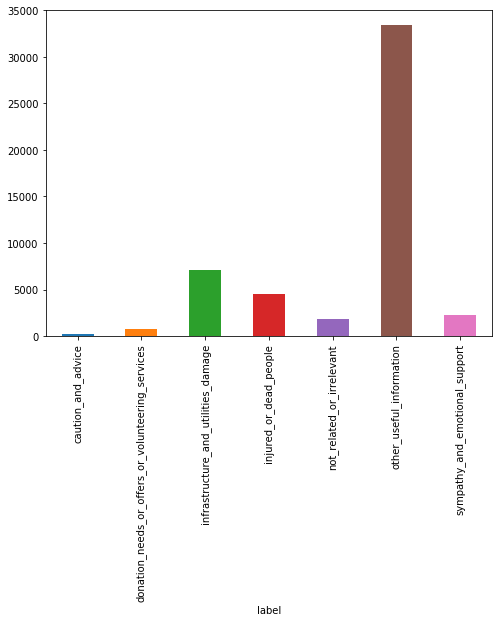

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('label').text.count().plot.bar(ylim=0)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.text).toarray()
labels = df.category_id
features.shape

(50000, 15788)

In [17]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for label, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(label))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'caution_and_advice':
  . Most correlated unigrams:
. funding
. govpressoffice
  . Most correlated bigrams:
. napaquake seismologist
. hope funding
# 'donation_needs_or_offers_or_volunteering_services':
  . Most correlated unigrams:
. onehottmess12
. help
  . Most correlated bigrams:
. community church
. crosswalk community
# 'infrastructure_and_utilities_damage':
  . Most correlated unigrams:
. building
. damage
  . Most correlated bigrams:
. historic building
. earthquake damage
# 'injured_or_dead_people':
  . Most correlated unigrams:
. injury
. injured
  . Most correlated bigrams:
. strong california
. cause injury
# 'not_related_or_irrelevant':
  . Most correlated unigrams:
. photo
. bgittleson
  . Most correlated bigrams:
. bgittleson photo
. photo california
# 'other_useful_information':
  . Most correlated unigrams:
. bgittleson
. injured
  . Most correlated bigrams:
. rt bgittleson
. bgittleson photo
# 'sympathy_and_emotional_support':
  . Most correlated unigrams:
. thought

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

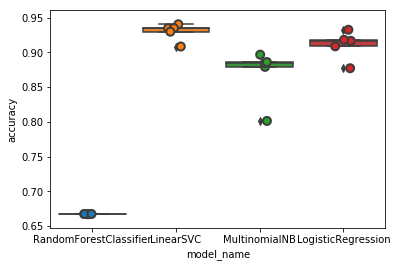

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [20]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.929619
LogisticRegression        0.910618
MultinomialNB             0.869557
RandomForestClassifier    0.667400
Name: accuracy, dtype: float64